In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import gc
import os 
import fpfs
import galsim
import numpy as np
import matplotlib.pylab as plt
from astropy.visualization import simple_norm
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy.lib.recfunctions as rfn

import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2.0 #set the value globally

# README
This notebook show the test on blended galaxies (center known)
+ we show a very extreme case --- shear estimation in extremely blended region!!
+ the center refers to the center of isotropy (at least free of spin-2 and spin-4)

2023/08/31 02:19:45 ---  Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023/08/31 02:19:45 ---  Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023/08/31 02:19:45 ---  Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023/08/31 02:19:45 ---  Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023/08/31 02:19:45 ---  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2023/08/31 02:19:46 ---  Order of the shear estimator: nnord=4
2023/08/31 02:19:46 ---  Shapelet kernel in configuration space: sigma= 0.4500 arcsec
2023/08/31 02:19:46 ---  Detection kernel in configuration space: sigma= 0.4500 arcsec
2023/08/31 02:19:47 ---

multiplicative bias is: 0.0007


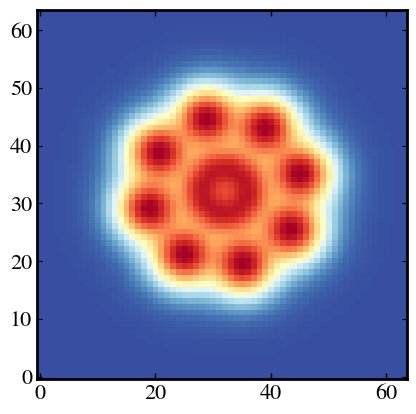

In [2]:
rcut=32
scale=0.168
ngrid=256
psfFWHM =   0.6
shear_value = 0.02

beg =   ngrid//2-rcut
end =   beg+2*rcut

psfInt = galsim.Moffat(
    beta=3.5, fwhm=0.6, trunc=0.6 * 4.0
).shear(e1=0.02, e2=-0.02)
psfData = psfInt.shift(0.5 * scale, 0.5 * scale).drawImage(nx=rcut*2, ny=rcut*2, scale=scale).array

ig= 445
outDir='galaxy_cosmo250_psf60'
results=[]
fpTask  =   fpfs.image.measure_source(psfData, sigma_arcsec=0.45)
#print(fpTask.klim)
nrot=4
for _ in range(nrot):
    rot2=np.pi/nrot*_
    gal=fpfs.simutil.make_cosmo_sim(outDir,psf_obj = psfInt, gname='g1-2222',ind0=ig,ny=ngrid,nx=ngrid,\
                                    rfrac=0.2,do_write=False,return_array=True, rot2=rot2, shear_value=shear_value)
    gal =   gal[beg:end,beg:end]
    modes=  fpTask.measure(gal) 
    modes = fpTask.get_results(modes)
    results.append(modes)
    
plt.close()
plt.imshow(gal,aspect='equal',cmap='RdYlBu_r',origin='lower',interpolation='None',\
             norm=simple_norm(gal,'asinh',asinh_a=0.1,min_cut=-0.01,max_cut=0.8))
mms =   rfn.stack_arrays(results,usemask=False)
ells=   fpfs.catalog.fpfs_m2e(mms,const=12)
resp=np.average(ells['fpfs_R1E'])
shear=np.average(ells['fpfs_e1'])/resp
print('multiplicative bias is: %.4f' %((shear-shear_value)/shear_value))